In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math

import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [54]:
%pwd

'/Users/edouardvilain/Desktop/3A - DSBA/BCG Data Challenge/code'

In [55]:
convention_df = pd.read_csv("../data/convention.csv", sep=";")
sts_df = pd.read_csv("../data/sts.csv", sep=";")
washington_df = pd.read_csv("../data/washington.csv", sep=";")

In [56]:
full_df = pd.concat([convention_df,sts_df,washington_df])
full_df = pd.read_csv("data_moyenne.csv", index_col=0)
full_df.drop(['hour', 'day', 'has_restriction'], axis=1, inplace=True)

In [57]:
full_df.columns

Index(['Identifiant arc', 'Libelle', 'Date et heure de comptage',
       'Débit horaire', 'Taux d'occupation', 'Etat trafic',
       'Identifiant noeud amont', 'Libelle noeud amont',
       'Identifiant noeud aval', 'Libelle noeud aval', 'Etat arc',
       'Date debut dispo data', 'Date fin dispo data', 'geo_point_2d',
       'geo_shape', 'moyenne débit', 'moyenne occupation'],
      dtype='object')

### Splitting Date et heure de comptage into multiple columns

In [58]:
full_df['date'] = pd.to_datetime(full_df['Date et heure de comptage'])
full_df['year'] = full_df['date'].apply(lambda x: x.year)
full_df['month'] = full_df['date'].apply(lambda x: x.month)
full_df['day'] = full_df['date'].apply(lambda x: x.day)
full_df['hour'] = full_df['date'].apply(lambda x: x.hour)

### Identifiant Arc

We determine the IDs of our arcs of interest:

In [35]:
washington_id = full_df[(full_df['Libelle noeud amont'] == "Av_Champs_Elysees-Washington") 
          & (full_df['Libelle noeud aval'] == "Av_Champs_Elysees-Berri")]["Identifiant arc"].unique()[0]
print("Arc ID for Washington:",washington_id)

Arc ID for Washington: 4264


In [36]:
convention_id = full_df[(full_df['Libelle noeud amont'] == "Lecourbe-Convention")
                               & (full_df['Libelle noeud aval'] == "Convention-Blomet")]["Identifiant arc"].unique()[0]
print("Arc ID for Convention:",convention_id)

Arc ID for Convention: 5671


In [37]:
stperes_id = full_df[(full_df['Libelle noeud amont'] == "Sts_Peres-Voltaire")
                       & (full_df['Libelle noeud aval'] == "Sts_Peres-Universite")]["Identifiant arc"].unique()[0]
print("Arc ID for St-Pères:",stperes_id)

Arc ID for St-Pères: 191


### Covid Data

Here we add which covid restrictions were in place at the time of the measurement:

In [38]:
full_df["covid_restrictions"] = full_df["Date et heure de comptage"].apply(lambda x: 'lockdown' if (((x >= '2020-03-17') & (x < '2020-05-11')) | ((x >= '2020-10-30') & (x < '2020-11-28')) | ((x >= '2021-03-20') & (x < '2021-05-19'))) else 
                                                                                    'curfew' if (((x >= '2021-01-18') & (x < '2021-03-20')) | ((x >= '2021-05-19') & (x < '2021-06-20'))) else
                                                                                    'free')

We also implement a binary variable, whose value is 1 at times when people were supposed to be home and 0 otherwise. During lockdown its value is always 1, during free time always 0 and during curfew 1 at times of curfew and 0 otherwise.

In [39]:
full_df["was_locked"] = full_df[["covid_restrictions","hour","Date et heure de comptage"]].apply(
    lambda x: 1 if x[0] == 'lockdown' else
                1 if ((x[0] == 'curfew') & ((x[2] >= '2021-01-18') & (x[2] < '2021-03-20')) & ((x[1] <= 5) | (x[1] >= 18))) else
                1 if ((x[0] == 'curfew') & ((x[2] >= '2021-05-19') & (x[2] < '2021-06-09')) & ((x[1] <= 5) | (x[1] >= 21))) else
                1 if ((x[0] == 'curfew') & (x[2] >= '2021-06-09') & ((x[1] <= 5) | (x[1] >= 23))) else
                0, axis=1)

### Holiday Data

Here we add a categorical variable taking values 0,1 or 2 whether Paris was respectively on working period, holidays or bank holidays.

In [40]:
full_df["Date et heure de comptage"].min()

'2020-11-01 04:00:00+01:00'

In [41]:
full_df["holidays"] = full_df["Date et heure de comptage"].apply(
    lambda x: 1 if ((x >= '2020-10-17') & (x < '2020-11-02')) else
                1 if ((x >= '2020-12-19') & (x < '2021-01-04')) else
                1 if ((x >= '2021-02-13') & (x < '2021-03-01')) else
                1 if ((x >= '2021-04-10') & (x < '2021-04-26')) else
                1 if ((x >= '2021-05-12') & (x < '2021-05-17')) else
                1 if ((x >= '2021-07-06') & (x < '2021-09-02')) else
                1 if ((x >= '2021-10-23') & (x < '2021-11-08')) else
                1 if ((x >= '2021-12-18') & (x < '2022-03-01')) else
                2 if ((x >= '2020-11-11') & (x < '2020-11-12')) else
                2 if ((x >= '2021-04-05') & (x < '2021-04-06')) else
                2 if ((x >= '2021-05-01') & (x < '2021-05-02')) else
                2 if ((x >= '2021-05-08') & (x < '2021-05-09')) else
                2 if ((x >= '2021-05-13') & (x < '2021-05-14')) else
                2 if ((x >= '2021-05-24') & (x < '2021-05-25')) else
                2 if ((x >= '2021-11-11') & (x < '2021-11-12')) else
                0)

In [42]:
full_df.groupby(["Etat trafic"]).count()

,Identifiant arc,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,...,moyenne débit,moyenne occupation,date,year,month,day,hour,covid_restrictions,was_locked,holidays
Etat trafic,,,,,,,,,,,,,,,,,,,,,
Bloqué,189,189,189,188,189,189,189,189,189,189,...,189,189,189,189,189,189,189,189,189,189
Fluide,23134,23134,23134,23085,23134,23134,23134,23134,23134,23134,...,23134,23134,23134,23134,23134,23134,23134,23134,23134,23134
Inconnu,480,480,480,6,0,480,480,480,480,480,...,480,480,480,480,480,480,480,480,480,480
Pré-saturé,3096,3096,3096,3087,3096,3096,3096,3096,3096,3096,...,3096,3096,3096,3096,3096,3096,3096,3096,3096,3096
Saturé,800,800,800,799,800,800,800,800,800,800,...,800,800,800,800,800,800,800,800,800,800


### Past Data

In this section, we add data from previous week at the same time to each row.

In [43]:
past_df = full_df[["Identifiant arc","date","Débit horaire","Taux d'occupation"]]
past_df['date'] = past_df['date'] + datetime.timedelta(7)
past_df = past_df.rename(columns={"Débit horaire":"Débit horaire_s-1", 
                                      "Taux d'occupation":"Taux d'occupation_s-1"})

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
# Joining past_df with full_df on "date" and "Identifiant arc"
full_df = pd.merge(full_df, past_df, how="left", on=["Identifiant arc","date"])

We apply a forward fill to our sorted data in order to prevent any issue with NaN values in our new features.

In [45]:
full_df = full_df.sort_values(["Identifiant arc","date"])

In [46]:
full_df[["Débit horaire_s-1","Taux d'occupation_s-1"]] = full_df[["Débit horaire_s-1","Taux d'occupation_s-1"]].fillna(method='ffill')

### Training Model

We will consider our tune and test data to be the 4 latest days of measurements in analogy with the method of evaluation. Test data will consist of the arcs we are demanded to predict while tune data will consist of all the remaining arcs. \
Training data will consist of the rest.

In [47]:
print("Oldest measurement: ", full_df['date'].min())
print("Most recent measurement: ", full_df['date'].max())

Oldest measurement:  2020-11-01 04:00:00+01:00
Most recent measurement:  2021-12-01 00:00:00+01:00


In this case, tune and test data will consist of measurements from the 27th of November to the 30th of November 2021.

In [48]:
train_df = full_df[full_df['Date et heure de comptage'] <= '2021-12-10 00:00:00+01:00']
tune_test_df = full_df[(full_df['Date et heure de comptage'] > '2021-12-10 00:00:00+01:00') 
                           & (full_df['Date et heure de comptage'] < '2021-12-31 00:00:00+01:00')]
tune_df = tune_test_df[(tune_test_df['Identifiant arc'] != 4264) 
                           & (tune_test_df['Identifiant arc'] != 5671)
                           & (tune_test_df['Identifiant arc'] != 191)]
test_df = tune_test_df[(tune_test_df['Identifiant arc'] == 4264) 
                           | (tune_test_df['Identifiant arc'] == 5671)
                           | (tune_test_df['Identifiant arc'] == 191)]

We then remove rows with missing values:

In [49]:
train_df = train_df.dropna()
tune_df = tune_df
test_df = test_df

In [50]:
print("Train Set Size:",train_df.shape[0])
print("Tune Set Size:",tune_df.shape[0])
print("Test Set Size:",test_df.shape[0])

Train Set Size: 26991
Tune Set Size: 0
Test Set Size: 0


Define features and targets:

In [51]:
features = ["Identifiant arc","Libelle","Identifiant noeud amont","Identifiant noeud aval","Etat arc",
                "geo_point_2d","year","month","day","hour","covid_restrictions","was_locked",
                "holidays","Débit horaire_s-1","Taux d'occupation_s-1",'moyenne débit', 'moyenne occupation', 'speed_limit']
cat_features = ["Identifiant arc","Libelle","Identifiant noeud amont","Identifiant noeud aval","Etat arc",
                "geo_point_2d","year","month","day","hour","covid_restrictions","was_locked",
                "holidays","speed_limit"]

#### Débit Model

In [ ]:
X_train_debit, y_train_debit = train_df[features], train_df["Débit horaire"]
X_tune_debit, y_tune_debit = tune_df[features], tune_df["Débit horaire"]
X_test_debit, y_test_debit = test_df[features], test_df["Débit horaire"]
X_train_occupation, y_train_occupation = train_df[features], train_df["Taux d'occupation"]
X_tune_occupation, y_tune_occupation = tune_df[features], tune_df["Taux d'occupation"]
X_test_occupation, y_test_occupation = test_df[features], test_df["Taux d'occupation"]

In [ ]:
train_pool_debit = cb.Pool(X_train_debit, y_train_debit,cat_features=cat_features)
train_pool_occupation = cb.Pool(X_train_occupation, y_train_occupation,cat_features=cat_features)
# tune_pool = cb.Pool(X_tune_debit, y_tune_debit,cat_features=cat_features)

In [88]:
model_debit = cb.CatBoostRegressor(loss_function="RMSE", verbose=False)
model_occupation = cb.CatBoostRegressor(loss_function="RMSE", verbose=False)

In [89]:
grid = {'iterations':[100,150,200],
           'learning_rate':[.1,.01,.001],
           'depth':[2,4,6,8],
           'l2_leaf_reg':[.2,.5,1]}

model_debit.grid_search(grid,train_pool_debit)
model_occupation.grid_search(grid,train_pool_occupation)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.


bestTest = 111.6623944
bestIteration = 99

0:	loss: 111.6623944	best: 111.6623944 (0)	total: 1.24s	remaining: 2m 13s

bestTest = 246.692981
bestIteration = 99

1:	loss: 246.6929810	best: 111.6623944 (0)	total: 2.54s	remaining: 2m 14s

bestTest = 479.875467
bestIteration = 99

2:	loss: 479.8754670	best: 111.6623944 (0)	total: 3.69s	remaining: 2m 9s

bestTest = 111.6659603
bestIteration = 99

3:	loss: 111.6659603	best: 111.6623944 (0)	total: 4.86s	remaining: 2m 6s

bestTest = 246.6947765
bestIteration = 99

4:	loss: 246.6947765	best: 111.6623944 (0)	total: 6.01s	remaining: 2m 3s

bestTest = 479.8759111
bestIteration = 99

5:	loss: 479.8759111	best: 111.6623944 (0)	total: 7.16s	remaining: 2m 1s

bestTest = 111.5952296
bestIteration = 99

6:	loss: 111.5952296	best: 111.5952296 (6)	total: 8.32s	remaining: 2m

bestTest = 246.6977688
bestIteration = 99

7:	loss: 246.6977688	best: 111.5952296 (6)	total: 9.46s	remaining: 1m 58s

bestTest = 479.8766513
bestIteration = 99

8:	loss: 479.8766513	b

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [90]:
# tune_pred = model_debit.predict(X_tune_debit)
test_pred_debit = model_debit.predict(X_test_debit)
test_pred_occupation = model_occupation.predict(X_test_occupation)

In [94]:
test_df["Débit horaire"] = test_pred_debit
test_df["Taux d'occupation"] = test_pred_occupation

In [100]:
test_df["Libelle"]

368445     Sts_Peres
368448     Sts_Peres
368452     Sts_Peres
368455     Sts_Peres
368458     Sts_Peres
             ...    
368789    Convention
368791    Convention
368795    Convention
368796    Convention
368799    Convention
Name: Libelle, Length: 357, dtype: object

In [96]:
import matplotlib.pyplot as plt

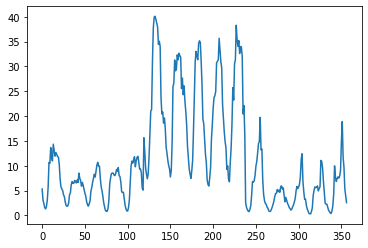

In [99]:
plt.plot(test_pred_occupation)

In [32]:
print("Tune MSE:",np.sqrt(mean_squared_error(y_tune_debit,tune_pred)))

Tune MSE: 73.64074193092544


In [33]:
print("Test MSE:",np.sqrt(mean_squared_error(y_test_debit,test_pred)))

Test MSE: 90.7263269417423


Compute MSE per each arc.

In [34]:
washington_true, washington_pred = y_test_debit[X_test_debit["Identifiant arc"] == 4264], test_pred[X_test_debit["Identifiant arc"] == 4264]
convention_true, convention_pred = y_test_debit[X_test_debit["Identifiant arc"] == 5671], test_pred[X_test_debit["Identifiant arc"] == 5671]
sts_true, sts_pred = y_test_debit[X_test_debit["Identifiant arc"] == 191], test_pred[X_test_debit["Identifiant arc"] == 191]

In [35]:
print("Washington MSE:",np.sqrt(mean_squared_error(washington_true,washington_pred)))
print("Convention MSE:",np.sqrt(mean_squared_error(convention_true,convention_pred)))
print("St-Pères MSE:",np.sqrt(mean_squared_error(sts_true,sts_pred)))

Washington MSE: 135.71035232003672
Convention MSE: 59.324267966837404
St-Pères MSE: 52.50838699093816


Plotting predictions.

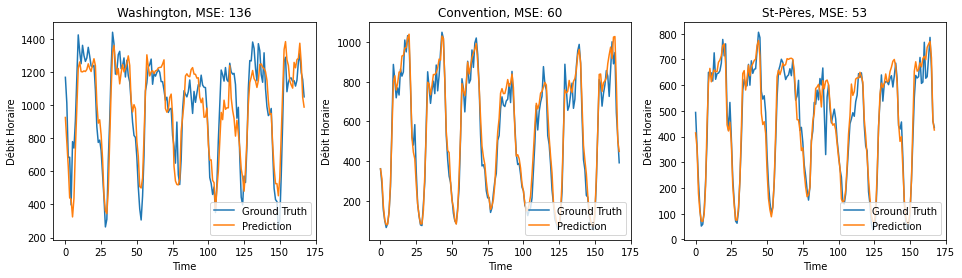

In [36]:
time = np.arange(168)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,4))

ax1.plot(time,washington_true,label="Ground Truth")
ax1.plot(time,washington_pred, label="Prediction")
ax1.set_title("Washington, RMSE: {}".format(math.ceil(np.sqrt(mean_squared_error(washington_true,washington_pred)))))
ax1.set_xlabel("Time")
ax1.set_ylabel("Débit Horaire")
ax1.legend(loc="lower right")

ax2.plot(time,convention_true,label="Ground Truth")
ax2.plot(time,convention_pred, label="Prediction")
ax2.set_title("Convention, RMSE: {}".format(math.ceil(np.sqrt(mean_squared_error(convention_true,convention_pred)))))
ax2.set_xlabel("Time")
ax2.set_ylabel("Débit Horaire")
ax2.legend(loc="lower right")

ax3.plot(time,sts_true,label="Ground Truth")
ax3.plot(time,sts_pred, label="Prediction")
ax3.set_title("St-Pères, RMSE: {}".format(math.ceil(np.sqrt(mean_squared_error(sts_true,sts_pred)))))
ax3.set_xlabel("Time")
ax3.set_ylabel("Débit Horaire")
ax3.legend(loc="lower right")

plt.show()